In [ ]:
#here we will apply a watershed binarisation with a hihg pass thrshold to the zeroth in order to create a mask

In [ ]:
#Imports 
import numpy as np
import matplotlib.pyplot as plt
import imageio as io
from skimage import data, img_as_float
from skimage.io import imread_collection
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage.util import crop
from skimage.morphology import binary_erosion, binary_dilation, cube
from skimage import filters
from skimage.filters import gaussian
import cv2

#Read in data for zeroth volume. This will be used as mask for the filter/cat phase.
vol_0 = img_as_float(crop(io.volread('E:/paper_2/Volumes_Bare/TiffSaver-tomo_B0X.tif'), ((0, 0),(0, 0), (0, 0)), copy=True))

#2d wise non local means
sigma_est = np.mean(estimate_sigma(vol_0, multichannel=False))
for z in range(0, 2110):
    vol_0[z] = denoise_nl_means(vol_0[z], h=4*sigma_est, fast_mode=True,
                                  patch_size=9, patch_distance=5, multichannel=False)
vol_0 = vol_0 * 255

#Gaussian Filter
vol_0 = gaussian(vol_0, sigma=0.20, output=None, mode='nearest', cval=0, multichannel=False, preserve_range=True, 
                        truncate=4.0)

for y in range(0, 2110):
    io.imwrite('E:/paper_2/Volumes_Bare/NLM0_TiffSaver/TiffSaver_%d.tif'%(y),
               vol_0[y].astype(np.uint8), format='tiff')

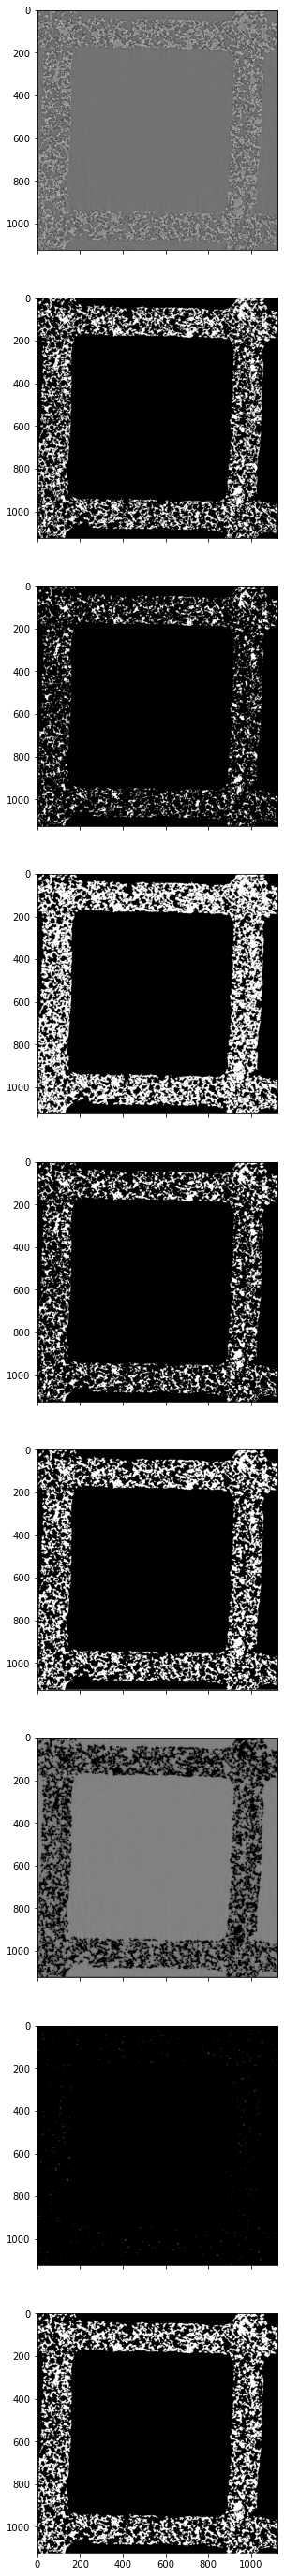

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imageio as io
from skimage import filters

kernel = np.ones((2, 2),np.uint8)

for z in range(0, 2110):
    #Apply binary threshold 1
    img = cv2.imread('E:/paper_2/Volumes_Bare/NLM0_TiffSaver/TiffSaver_%d.tif'%(z))
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    thresh_yen = filters.threshold_yen(img.astype('uint8'))
    ret, thresh = cv2.threshold(gray,thresh_yen+7,255,cv2.THRESH_BINARY)
    
    #Erosion/Dilation of binary 1 and defining 'sure foreground & background' for watershed labels
    #sure foreground
    sure_fg = cv2.erode(thresh,kernel,iterations=2)
    sure_fg = sure_fg.astype(np.uint8)
    
    # sure background area
    sure_bg = cv2.dilate(thresh,kernel,iterations=2)
    sure_bg = sure_bg.astype(np.uint8)
    
    # Finding unknown region
    unknown = cv2.subtract(sure_bg,sure_fg)
    
    #Marker labelling
    ret, markers = cv2.connectedComponents(sure_fg)
    
    #Add one to all labels so that sure background is not 0, but 1
    markers = markers+1
    
    #Now, mark the region of unknown with zero
    markers[unknown==255] = 0
    
    #best solution was watershed (inc. boundary pixels) + a high pass threshold for high intensity pixels missed by watershed
    markers = cv2.watershed(img,markers)
    markers_binary = markers > 1
    unknown = markers < 1
    markers_binary_unknown = markers_binary + unknown
    masked = gray * (1 - markers_binary_unknown)
    masked_highpass = masked > thresh_yen + 29
    final_mask = markers_binary_unknown + masked_highpass
    
    #save slice
    io.imwrite('E:/paper_2/Volumes_Bare/Mask_TiffSaver/TiffSaver_%d.tif'%(z), final_mask.astype(np.uint8), format='tiff')
    
#Plot images illustrating process
fig, axes = plt.subplots(nrows=9, ncols=1, figsize = (50, 50), 
                         sharex=True, sharey=True)
axes[0].imshow(img, cmap = 'gray')
axes[1].imshow(thresh, cmap = 'gray')
axes[2].imshow(sure_fg, cmap = 'gray')
axes[3].imshow(sure_bg, cmap='gray')
axes[4].imshow(markers_binary, cmap='gray')
axes[5].imshow(markers_binary_unknown, cmap='gray')
axes[6].imshow(masked, cmap='gray')
axes[7].imshow(masked_highpass, cmap='gray')
axes[8].imshow(final_mask, cmap='gray')

In [ ]:
#this is then loaded into avizo so that some streaking artifacts can be removed manually